In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
# 1. Load dataset
df = pd.read_excel("SuperEmotionDataset.xlsx", engine="openpyxl", header=None)
df = df[0].str.split(",", n=4, expand=True)
df.columns = ["text", "labels", "labels_str", "labels_source", "source"]

In [4]:
# 2. Clean labels (remove brackets and quotes)
df["labels_str"] = df["labels_str"].apply(lambda x: re.sub(r"[\[\]']", "", x).strip())

In [5]:
# 3. Keep only selected emotions
target_emotions = ["Joy", "Sadness", "Anger", "Neutral"]
df = df[df["labels_str"].isin(target_emotions)]

print("Dataset shape:", df.shape)
print(df["labels_str"].value_counts())

Dataset shape: (385775, 5)
labels_str
Joy        161400
Sadness    133887
Anger       68102
Neutral     22386
Name: count, dtype: int64


In [6]:
# 4. Features and labels
X = df["text"]
y = df["labels_str"]

In [7]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# 6. Vectorize text
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
# 7. Train model
model = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [10]:
# 8. Evaluate
y_pred = model.predict(X_test_tfidf)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9088717516687188

Classification Report:
               precision    recall  f1-score   support

       Anger       0.90      0.87      0.88     13620
         Joy       0.98      0.92      0.95     32280
     Neutral       0.49      0.93      0.64      4477
     Sadness       0.97      0.92      0.94     26778

    accuracy                           0.91     77155
   macro avg       0.83      0.91      0.85     77155
weighted avg       0.93      0.91      0.92     77155



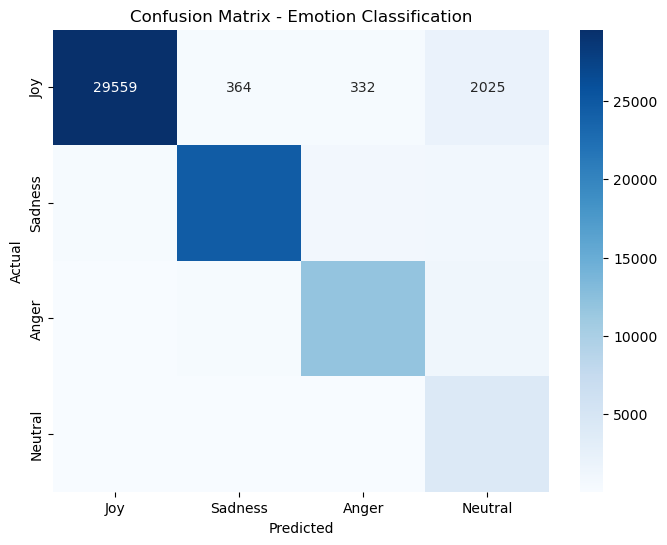

In [11]:
# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=target_emotions)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_emotions, yticklabels=target_emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Emotion Classification")
plt.show()

In [12]:
# 🔹 10. Gradio Interface
import gradio as gr

def predict_emotion(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Textbox(lines=1, placeholder="Type a sentence here..."),
    outputs="text",
    title="Emotion Classifier",
    description="Enter a sentence and the model will predict its emotion (Joy, Sadness, Anger, Neutral)."
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
